Knowledge Distillation with Pytorch on MNIST


In [ ]:
import torch
import torchvision


from IPython.display import clear_output
import time
import tqdm
from tqdm import tqdm_notebook
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
torch.cuda.is_available()

True

There are teacher neural network  and student neural network here. Each network constitutes convolutional neural networks that is composed of 2 layers and one linear layer, whose main goal is to obtain logits. The distinguishing of these networks is that student neura network has less filters(kernels) in each layer unless teacher  neural network. The main goal is to train student network in order to get the same predictions as teacher network.

In [ ]:
class Teacher(torch.nn.Module): 
  def __init__(self):
    super().__init__()
    self.teacher_net = torch.nn.Sequential(
        torch.nn.Conv2d(in_channels = 3 ,out_channels = 256, kernel_size = 3 ,stride = 2, padding = 1 ,bias = True),
        torch.nn.BatchNorm2d(256),
        torch.nn.LeakyReLU(0.2),
        # [batch, 256, 16,16]
        

        torch.nn.MaxPool2d(kernel_size = 2, stride = 1 , padding =1),
        # [batch, 256, 17,17]

        torch.nn.Conv2d(in_channels = 256 , out_channels = 512 ,kernel_size = 3, stride = 2, padding = 1),
        torch.nn.BatchNorm2d(512)
        # [batch, 512, 9, 9]
        
    )

    self.fc = torch.nn.Sequential( 
        torch.nn.Linear(in_features = 512*9*9  , out_features = 300),
        torch.nn.LeakyReLU(0.2),
        torch.nn.Linear(in_features = 300, out_features = 10)
    )

  def forward(self,x):
    x = self.teacher_net(x)
    x = x.view(-1, 512*9*9)
    return self.fc(x) # return [batch, 10] i.e batch of logits for each class

In [65]:
class Student(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.student_net = torch.nn.Sequential(
      torch.nn.Conv2d(in_channels = 3 ,out_channels = 16, kernel_size = 3 ,stride = 2, padding = 1 ,bias = True),
      torch.nn.BatchNorm2d(16),
      torch.nn.LeakyReLU(0.2),
      # [batch, 16,16,16]

      torch.nn.MaxPool2d(kernel_size = 2, stride = 1 , padding =1),
      # [batch, 16,17,17]

      torch.nn.Conv2d(in_channels = 16 , out_channels = 32 ,kernel_size = 3, stride = 2, padding = 1),
      torch.nn.BatchNorm2d(32)
      # [batch,32,9,9]
    )
    self.fc = torch.nn.Sequential(
        torch.nn.Linear(in_features = 32*9*9 , out_features= 100),
        torch.nn.LeakyReLU(0.2),
        torch.nn.Linear(in_features = 100 ,out_features = 10),

    )

    
  def forward(self,x):
    x = self.student_net(x)
    x = x.view(-1,32*9*9)
    return self.fc(x) # return [batch,10] i.e batch of logits for each class

In [ ]:
class Distiller(torch.nn.Module):
  
  def __init__(self, student, teacher,optimizer,student_loss_fn,distillation_loss_fn,
               alpha,temperature):
    
    super().__init__()
    self.teacher = teacher
    self.student = student
    self.optimizer = optimizer
    self.student_loss_fn = student_loss_fn
    self.distillation_loss_fn = distillation_loss_fn
    self.alpha = alpha
    self.temperature = temperature
  
  
  # one train step 
  def train_step(self, x,y):
    
    self.optimizer.zero_grad()
    teacher_predictions = self.teacher(x).detach()
    # since we don't want train teacher model
    
    # x : torch.Size([batch,1,28,28])
    # y: torch.Size ([batch])
    student_predictions = self.student(x)
    # student_predictions : torch.Size([batch,10])

     

    distillation_loss = self.distillation_loss_fn(torch.nn.Softmax(dim=1)(student_predictions/self.temperature),
                                                  torch.nn.Softmax(dim=1)(teacher_predictions/self.temperature)).sum(1).mean()
    # distillation_loss : torch.Size([])
    
    student_loss = self.student_loss_fn(student_predictions, y.long().cuda()) #  loss of the ground-truth labels

    
    student_loss =  ( 1 - self.alpha )*distillation_loss +  self.alpha*student_loss
    student_loss.backward()
    self.optimizer.step()


    train_loss = np.sum(student_loss.detach().cpu().numpy())
    y_pred = student_predictions.max(1)[1].detach().cpu().numpy()
    train_acc = np.mean(y.cpu().numpy() == y_pred)

    return train_loss,train_acc



  def test_step(self, x,y):

    student_logits = self.student(x).detach()
    student_loss = self.student_loss_fn(student_logits,y.long().cuda())
    
    val_loss = np.sum(student_loss.cpu().numpy())
    y_pred = student_logits.max(1)[1].cpu().numpy()
    val_acc = np.mean(y.cpu().numpy() == y_pred)

    return val_loss, val_acc


Then, one can prepare the dataset for training of the student network

In [ ]:
train_val_dataset = torchvision.datasets.CIFAR10(root='./data',train=True,transform=torchvision.transforms.ToTensor(),download=True)
test_dataset = torchvision.datasets.CIFAR10(root='./data',train=False, transform=torchvision.transforms.ToTensor(),download=True)
train_dataset, val_dataset = torch.utils.data.random_split(train_val_dataset, [40000,10000])

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
BATCH_SIZE = 64
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

The following code is aimed to train teacher. Since , we are inclined to believe that teacher is fixed while stident is training .So, let's train the teacher



In [ ]:
teacher = Teacher().cuda()
optimizer_teacher = torch.optim.Adam(teacher.parameters(),lr=1e-3)
criterion = torch.nn.CrossEntropyLoss()

In [ ]:
def linear(num_epoch,start = 0, finish = 50,start_LR = 1e-3 ,finish_LR = 0):
  tau = min(1,max(0,( finish - num_epoch)/(finish - start)))
  return 1000*(tau*start_LR + (1-tau)*finish_LR)

In [ ]:
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer_teacher,linear)

In [ ]:
def plot_learning_curves(history):
    '''
     
    This function is aimed to show up at all loss and accuracy (metrics) during the training of the model

    :param history: (dict)
        accuracy and loss on the training and validation
    '''
    # sns.set_style(style='whitegrid')

    fig = plt.figure(figsize=(20, 7))

    plt.subplot(1,2,1)
    plt.title('Loss', fontsize=15)

    plt.plot(history['loss']['train'], label='train')
    plt.plot(history['loss']['val'], label='validation')

    plt.ylabel('Loss', fontsize=15)
    plt.xlabel('Num epochs', fontsize=15)
    plt.legend()

    plt.subplot(1,2,2)
    plt.title('Accuracy', fontsize=15)
    plt.plot(history['acc']['train'], label='train')
    plt.plot(history['acc']['val'], label='validation')
    plt.ylabel('Accuracy', fontsize=15)
    plt.xlabel('Num epochs', fontsize=15)
    plt.legend()
    plt.show()

In [ ]:
def train_teacher(num_epochs,
                  model,
                  train_loader,
                  criterion,
                  optimizer,
                  val_loader):
  
  history = defaultdict(lambda: defaultdict(list))
  for epoch in tqdm_notebook(range(num_epochs)):

    train_loss = 0
    train_acc = 0
    val_loss = 0
    val_acc = 0

    start_time = time.time()
    model.train(True)

    for x_batch, y_batch in tqdm_notebook(train_loader):
      x_batch,y_batch = x_batch.cuda(),y_batch.cuda()

      optimizer.zero_grad()

      logits = model(x_batch)
      loss = criterion( logits, y_batch.long().cuda())
      
      loss.backward()
      optimizer.step()

      train_loss += np.sum(loss.detach().cpu().numpy())
      y_pred = logits.max(1)[1].detach().cpu().numpy()
      train_acc += np.mean(y_batch.cpu().numpy() == y_pred)
    
    # calculate loss and accuracy and  save to "историю"
    train_loss /= len(train_loader)
    train_acc /= len(train_loader) 
    history['loss']['train'].append(train_loss)
    history['acc']['train'].append(train_acc)

    scheduler.step()

    model.eval()
    for batch_x, batch_y in tqdm_notebook(val_loader):
      batch_x,batch_y = batch_x.cuda(),batch_y.cuda()

      logits = model(batch_x)
      loss = criterion(logits, batch_y.long().cuda())

      val_loss += np.sum(loss.detach().cpu().numpy())
      y_pred = logits.max(1)[1].detach().cpu().numpy()
      val_acc += np.mean(batch_y.cpu().numpy() ==  y_pred)
    
    val_loss /= len(val_loader)
    val_acc /= len(val_loader) 
    history['loss']['val'].append(val_loss)
    history['acc']['val'].append(val_acc)

    clear_output()
        
    #print results after each epoch
    print("Epoch {} of {} took {:.3f}s".format(
              epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration): \t{:.6f}".format(train_loss))
    print("  validation loss (in-iteration): \t{:.6f}".format(val_loss))
    print("  training accuracy: \t\t\t{:.2f} %".format(train_acc * 100))
    print("  validation accuracy: \t\t\t{:.2f} %".format(val_acc * 100))
    plot_learning_curves(history)
  return model, history

Epoch 50 of 50 took 19.999s
  training loss (in-iteration): 	0.000098
  validation loss (in-iteration): 	2.759360
  training accuracy: 			100.00 %
  validation accuracy: 			71.17 %


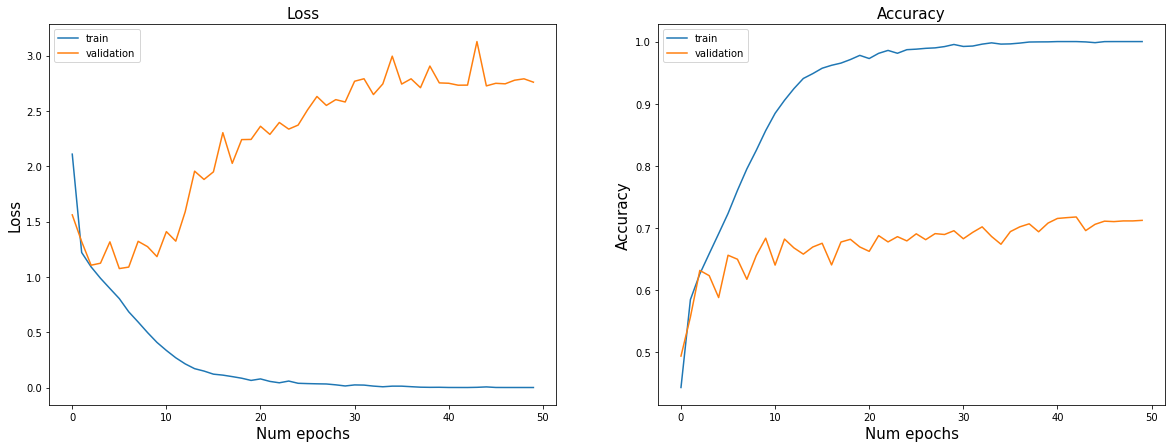

In [51]:
model, history = train_teacher(50,teacher, train_loader, criterion,optimizer_teacher,val_loader)

As soon as we trained the teacher model, one can move on to distillation.

In [66]:
student = Student().cuda()

In [67]:
distiller = Distiller(student, teacher, optimizer=torch.optim.Adam(student.parameters(),lr=1e-3),
                 student_loss_fn = torch.nn.CrossEntropyLoss(),distillation_loss_fn = torch.nn.KLDivLoss(reduction='none'),
                 alpha = 0.1,temperature = 3)

Train student model via the teacher model

In [68]:
def train_student(num_epochs,distiller,train_loader,val_loader):

  history = defaultdict(lambda: defaultdict(list))
  for epoch in tqdm_notebook(range(num_epochs)):
    
    distiller.student.train(True)

    train_loss = 0
    train_acc = 0
    val_loss = 0
    val_acc = 0

    start_time = time.time()
     
    for data,label in train_loader:
      data = data.cuda()
      label = label.cuda()
      loss,acc = distiller.train_step(data,label)
      train_loss += loss
      train_acc += acc
    
    train_loss /= len(train_loader)
    train_acc /= len(train_loader) 
    history['loss']['train'].append(train_loss)
    history['acc']['train'].append(train_acc)

    distiller.student.eval()
    with torch.no_grad():
      for data,label in val_loader:
        data = data.cuda()
        label = label.cuda()
        loss_,acc_ = distiller.test_step(data,label)
        val_loss += loss_
        val_acc += acc_
      
      val_loss /= len(val_loader)
      val_acc /= len(val_loader) 
      history['loss']['val'].append(val_loss)
      history['acc']['val'].append(val_acc)

      clear_output()
      #print results after each epoch
      print("Epoch {} of {} took {:.3f}s".format(
          epoch + 1, num_epochs, time.time() - start_time))
      print("  training loss (in-iteration): \t{:.6f}".format(train_loss))
      print("  validation loss (in-iteration): \t{:.6f}".format(val_loss))
      print("  training accuracy: \t\t\t{:.2f} %".format(train_acc * 100))
      print("  validation accuracy: \t\t\t{:.2f} %".format(val_acc * 100))
        
      plot_learning_curves(history)
  

  return  distiller.student, history




Epoch 10 of 10 took 8.487s
  training loss (in-iteration): 	-0.694852
  validation loss (in-iteration): 	3.247769
  training accuracy: 			84.97 %
  validation accuracy: 			65.16 %


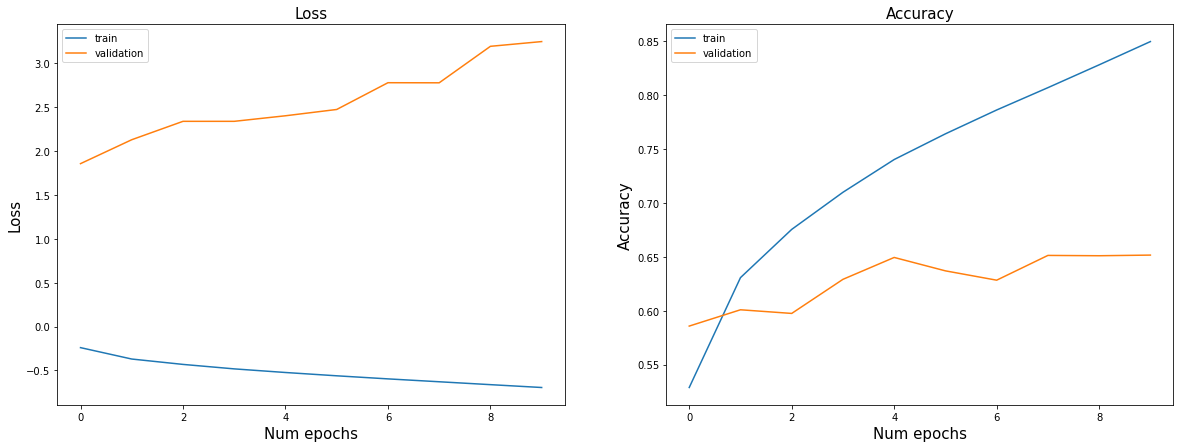

In [69]:
student,history = train_student(10,distiller,train_loader,val_loader)

https://keras.io/examples/vision/knowledge_distillation/